# Phase 1 of project: Data Wrangling

- We will be using the mnist dataset for this project.
- The first iteration will use pytorch

In [1]:
# load the dataset

from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('Train: X=%s, y=%s' % (train_X.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_X.shape, test_y.shape))

2022-10-12 15:16:24.008034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


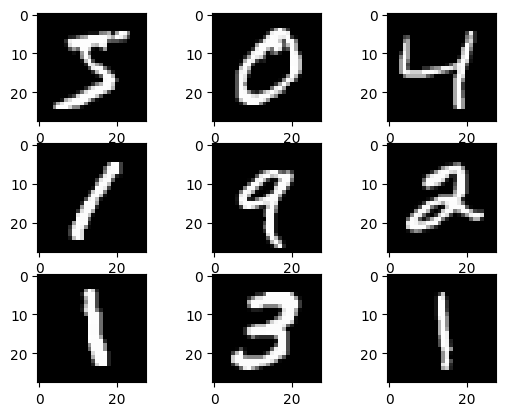

In [2]:
# plot the dataset

import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()


In [3]:
import numpy as np
from itertools import product
# pooling the dataset
# mode = max, mean
def pooling_layer2D(X, spatial_extent=2, stride=2, mode='max'):
    X = np.asarray(X)
    h, w = X.shape
    h_out = int((h - spatial_extent) / stride) + 1
    w_out = int((w - spatial_extent) / stride) + 1
    #get the max/mean value in the spatial extent stride by stride
    Y = np.zeros((h_out, w_out))
    for i, j in product(range(h_out), range(w_out)):
        if mode == 'max':
            Y[i, j] = np.max(X[i * stride:i * stride + spatial_extent, j * stride:j * stride + spatial_extent])
        elif mode == 'mean':
            Y[i, j] = np.mean(X[i * stride:i * stride + spatial_extent, j * stride:j * stride + spatial_extent])
    return Y

In [4]:
import numpy as np
from itertools import product
# conv the dataset
#num_filters = powers of 2
#rand = [0,1)
def filter_gen(spatial_extent, num_filters):
    return np.random.rand(num_filters, spatial_extent, spatial_extent) -0.5

def kfilter_scan(X, num_filters, spatial_extent, stride, zero_padding):
    X = np.asarray(X)
    h, w = X.shape
    #add zero padding
    if zero_padding:
        X = np.pad(X, spatial_extent // 2)
    w_out = int((w - spatial_extent + (2*zero_padding)) / stride) + 1
    h_out = int((h - spatial_extent + (2*zero_padding)) / stride) + 1

    filters = filter_gen(spatial_extent, num_filters)
    #get the max/mean value in the spatial extent stride by stride
    Y = np.zeros((h_out, w_out))
    #dot product of the filter and the image at each stride
    for i, j in product(range(h_out), range(w_out)):
        temp = X[i * stride:i * stride + spatial_extent, j * stride:j * stride + spatial_extent]
        Y[i,j] = np.dot(temp.flatten(), filters[0].flatten())      
    return Y

In [5]:
def relu(x):
    return np.maximum(0, x)

def relu_layer(image):
    h, w = image.shape
    new_image = np.zeros((h, w))
    for  i, j in product(range(h), range(w)):
        new_image[i,j] = relu(image[i,j])
    return new_image
        
     

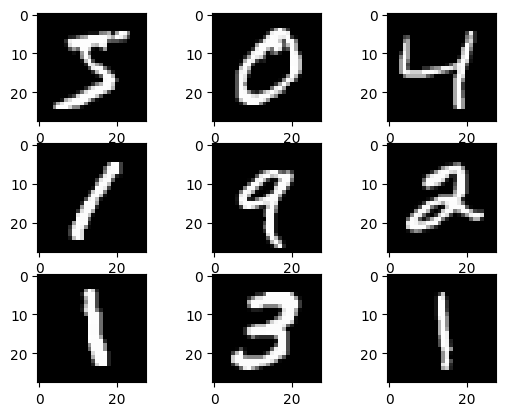

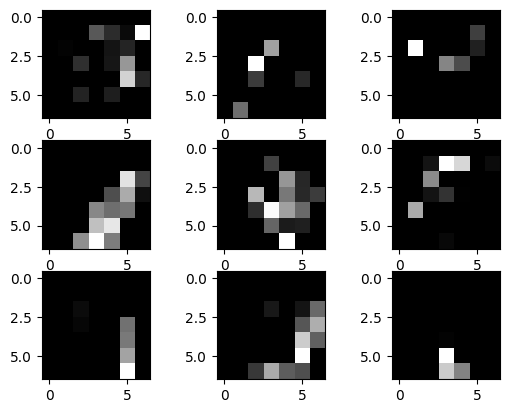

In [6]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

for i in range(9):
    poollayer = pooling_layer2D(train_X[i], spatial_extent=2, stride=2, mode='max')
    filtered = kfilter_scan(poollayer, num_filters=2, spatial_extent=4, stride=2, zero_padding=1)
    relued = relu_layer(filtered)
    plt.subplot(330 + 1 + i)
    plt.imshow(relued, cmap=plt.get_cmap('gray'))
plt.show()